In [422]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

import gym
import hiive.mdptoolbox as mdptoolbox
from hiive.mdptoolbox.mdp import PolicyIteration, ValueIteration, QLearning
import random
np.random_seed = 0
%matplotlib inline

# Helper Functions

In [423]:
# Helper functions
def plot_policy(policy, state_rewards, title='Policy'):
    directions = ['←', '↓', '→', '↑']
    policy_symbols = [directions[action] for action in policy]
    
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_title(title, fontsize=16, weight='bold', y=1.01)
    
    cmap = plt.cm.coolwarm  # Colormap for coloring based on rewards
    vmin, vmax = np.min(state_rewards), np.max(state_rewards)  # Min and max reward values
    
    for i in range(4):
        for j in range(4):
            index = i * 4 + j
            color = cmap((state_rewards[i][j] - vmin) / (vmax - vmin))  # Map reward to colormap
            ax.add_patch(plt.Rectangle((j, i), 1, 1, color=color, alpha=0.8))  # Draw colored rectangle
            plt.text(j + 0.5, i + 0.5, policy_symbols[index], ha='center', va='center', fontsize=20, color='white')
    
    ax.axis('off')
    plt.show()


def plot_heatmap(data, title="Value Function"):
    plt.imshow(data.reshape((8,8)))
    plt.title(title)
    plt.colorbar()
    plt.show()

# Plot the environment
def plot_environment(env):
    # Extract the environment map from the env
    desc = env.desc.astype(str).tolist()
    #desc = [[c.decode('utf-8') for c in line] for line in desc]

    # Map characters to colors
    color_map = {
        'S': 'blue',  # Start
        'F': 'red',  # Frozen surface
        'H': 'black',  # Hole
        'G': 'green'  # Goal
    }

    # Create the image of the environment
    plt.figure(figsize=(5,5))
    for i, row in enumerate(desc):
        for j, cell in enumerate(row):
            plt.text(j, i, cell, ha='center', va='center', color=color_map[cell], fontsize=30)

    #plt.title('Frozen Lake Environment')
    plt.axis('off')
    plt.show()

def get_number_of_steps(env, policy, episodes=1000):
    misses = 0
    steps_for_all_episodes = []
    for each_episode in range(episodes):
        state = env.reset()[0]
        steps = 0
        while True:
            action = policy[state]
            state, reward, done, _, prob = env.step(action)
            steps += 1
            if done and reward == 0:
                misses += 1
                break
            elif done and reward == 1:
                steps_for_all_episodes.append(steps)
                break
    mean_steps = np.mean(steps_for_all_episodes)
    std_steps = np.std(steps_for_all_episodes)
    fail_percentage = (misses/episodes) * 100
    return mean_steps, std_steps, fail_percentage



In [424]:
def run_episodes(env, num_games, policy,  random=False):
    total_reward = 0
    total_wins = 0
    for _ in range(num_games):
        state = env.reset()[0]
        done = False
        while not done:
            if random:
                action = env.action_space.sample()
            else:
                action = policy[state]
            state, reward, done, info, _ = env.step(action)
            total_reward += reward
            if done:
                total_wins+=1
                break
                
    avg_reward = total_reward / num_games
    return total_wins,total_reward, avg_reward

In [425]:
colors = {
    b'S': 'r',
    b'F': 'w',
    b'H': 'k',
    b'G': 'g'
}

directions = {
            0: '←',
            1: '↓',
            2: '→',
            3: '↑'
}

def plot_lake(env, policy=None, title='Frozen Lake'):
    squares = env.nrow
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, xlim=(-.01, squares+0.01), ylim=(-.01, squares+0.01))
    plt.title(title, fontsize=16, weight='bold', y=1.01)
    for i in range(squares):
        for j in range(squares):
            y = squares - i - 1
            x = j
            p = plt.Rectangle([x, y], 1, 1, linewidth=1, edgecolor='k')
            p.set_facecolor(colors[env.desc[i,j]])
            ax.add_patch(p)
            
            if policy is not None:
                text = ax.text(x+0.5, y+0.5, directions[policy[i, j]],
                               horizontalalignment='center', size=25, verticalalignment='center',
                               color='k')
            
    plt.axis('off')
    plt.savefig(title + '.png', dpi=400)

In [426]:
def construct_transition_matrix(env):
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    P = np.zeros((n_actions, n_states, n_states))
    for s in range(n_states):
        for a in range(n_actions):
            for transition in env.P[s][a]:
                probability, next_state, reward, done = transition
                P[a, s, next_state] += probability
    return P

def construct_reward_matrix(env):
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    R = np.zeros((n_states, n_actions))
    for s in range(n_states):
        for a in range(n_actions):
            for transition in env.P[s][a]:
                probability, next_state, reward, done = transition
                R[s, a] = reward
    return R

In [427]:
def calculate_state_value_function(env, state, V, discount_factor):
    A = np.zeros(env.action_space.n)
    for a in range(env.action_space.n):
        for prob, next_state, reward, info in env.P[state][a]:
            A[a] += prob * (reward + discount_factor * V[next_state])
    return A

def update_policy(env, policy, V, discount_factor):
    for each_state in range(env.observation_space.n):
        A = calculate_state_value_function(env, each_state, V, discount_factor)
        best_action = np.argmax(A)
        policy[each_state] = best_action
    return policy

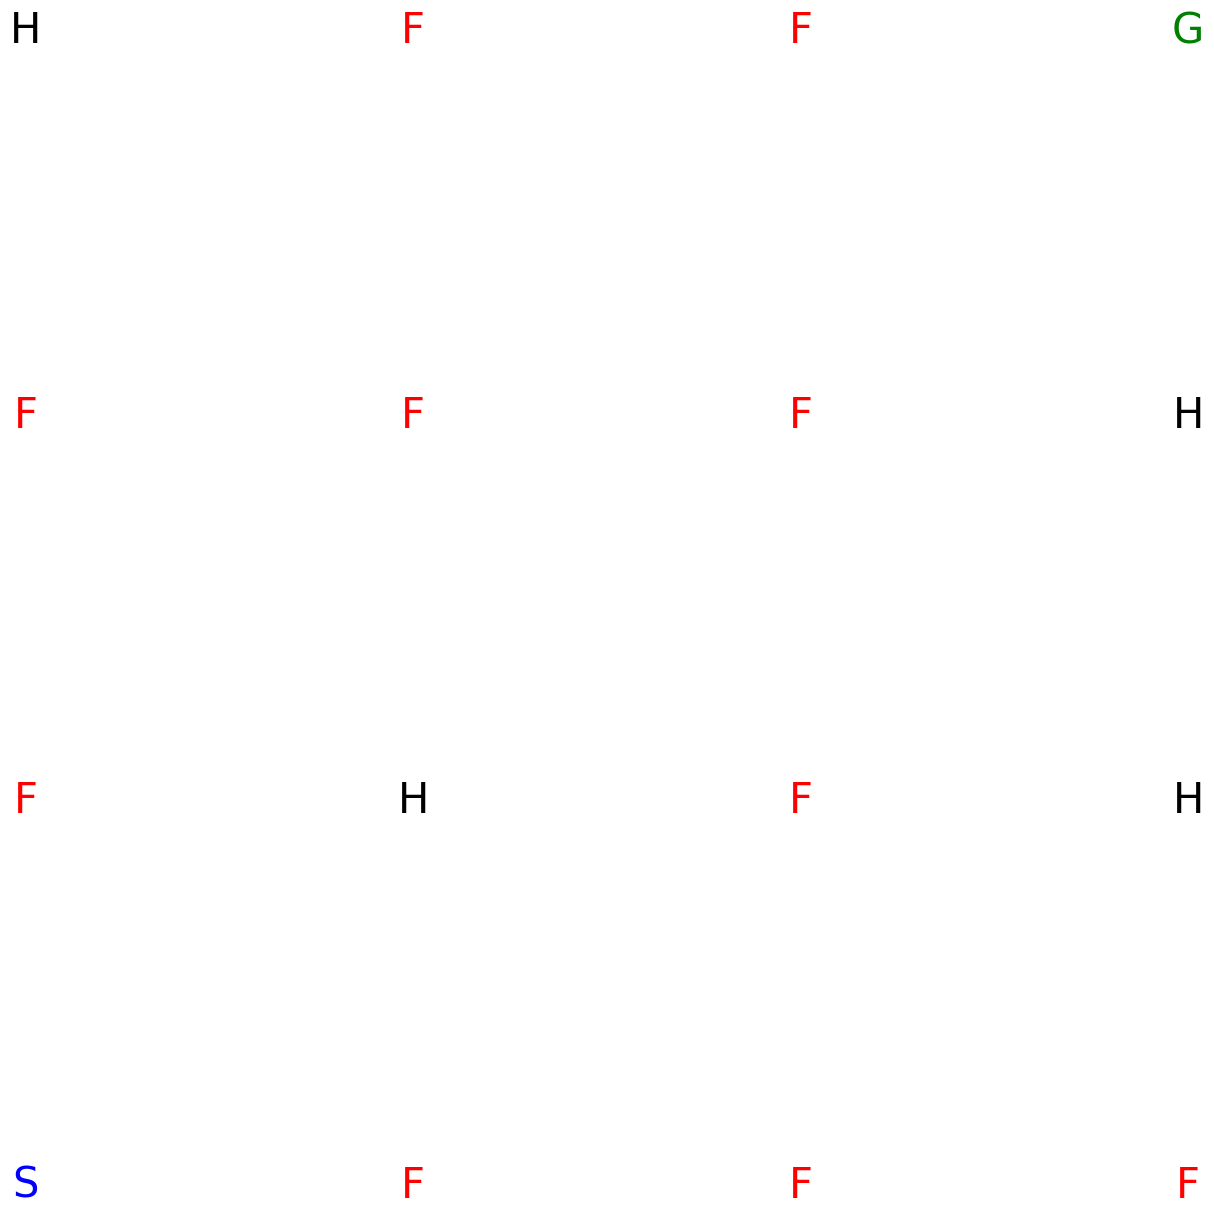

In [428]:
# Load  FrozenLake-v0 environment
env = gym.make('FrozenLake-v1').unwrapped
#env = gym.make('FrozenLake8x8-v1').unwrapped
env.max_episode_steps = 250

rows, cols = env.nrow, env.ncol
# Define Transition Matrix and Reward Matrix Placeholders
T = np.zeros((8, rows, cols))
R = np.zeros((8, rows, cols))
plot_environment(env)

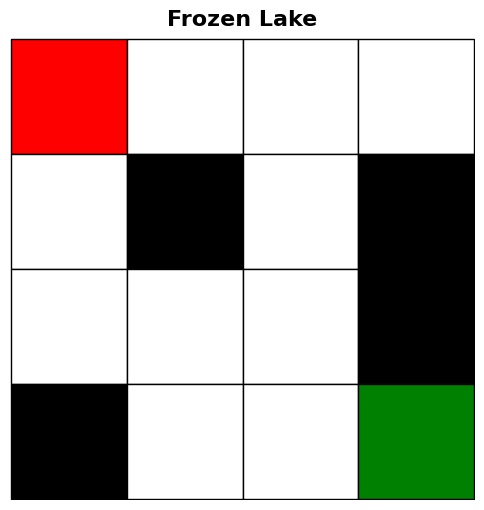

In [429]:
plot_lake(env)

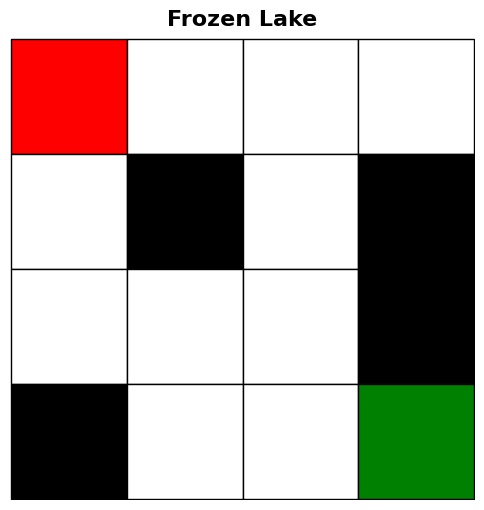

In [430]:
plot_lake(env)

# Value Iteration Experiments

In [431]:
def run_value_iteration_exp(t, r, gamma_values, epsilons, max_iterations=100000):
    start_time = time.time()
    value_iterations = []

    test_number = 0

    for gamma in gamma_values:
        for epsilon in epsilons:
            vi = ValueIteration(t, r, gamma, epsilon, max_iter=max_iterations)
            test_run = vi.run()

            max_reward = test_run[-1]['Reward'] # max reward
            time_to_converge = test_run[-1]['Time'] # time to converge
            num_iters = test_run[-1]['Iteration'] # number of iterations to converge
            reward = test_run[-1]['Max V'] # max V value

            # Collect mean V, max V and errors
            max_r, mean_r, errors = [], [], []
            for run in test_run:
                max_r.append(run['Max V'])
                mean_r.append(run['Mean V'])
                errors.append(run['Error'])

            policy = np.array(vi.policy)
            #policy
            #policy = policy.reshape((4,4))
            value_iterations.append([gamma, epsilon, max_reward, time_to_converge, 
                                     num_iters, reward, max(max_r), max(mean_r), max(errors), policy])
            test_number += 1
            end_time = time.time() - start_time

    #print ("Policy>>",policy)

    value_iterations_df = pd.DataFrame(value_iterations, columns=['Gamma', 'Epsilon', 'Max Reward', 'Time to Converge', 'Num Iters', 'Reward', 'Max V (All)', 'Mean V (All)', 'Errors', 'Policy'])
    #print('Time to converge: ', end_time)

    #print (value_iterations_df.head())
    
    # See differences in policy
    policies = value_iterations_df['Policy']
    for i, policy in enumerate(policies):
        pol = np.array(policy)
        #print (pol)
        steps, steps_stddev, failures = get_number_of_steps(env, pol)
        value_iterations_df.loc[i, 'Mean Steps'] = steps
        value_iterations_df.loc[i, 'Std Steps'] = steps_stddev
        value_iterations_df.loc[i, 'Failures'] = failures
    value_iterations_df.fillna(0, inplace=True)
    return value_iterations_df

### Experiment 1

In [432]:
# Changing value of Gamma
gamma_values = [0.1,0.2, 0.3, 0.5, 0.7, 0.9, 0.99]
epsilons = [1e-2, 1e-3, 1e-5, 1e-8]

# Define the transition probability matrix and reward matrix from the environment
P = construct_transition_matrix(env)
R = construct_reward_matrix(env)

value_iterations = run_value_iteration_exp(P, R, gamma_values, epsilons)
value_iterations.to_csv('value_iterations.csv', index=False)
value_iterations.head()

C:\Users\vyassum\AppData\Roaming\Python\Python310\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\vyassum\AppData\Roaming\Python\Python310\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\vyassum\AppData\Roaming\Python\Python310\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\vyassum\AppData\Roaming\Python\Python310\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\vyassum\AppData\Roaming\Python\Python310\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\vyassum\AppData\Roaming\Python\

,Gamma,Epsilon,Max Reward,Time to Converge,Num Iters,Reward,Max V (All),Mean V (All),Errors,Policy,Mean Steps,Std Steps,Failures
0,0.1,1.000000e-02,1.033333,0.000000,2,1.033333,1.033333,0.068750,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0]",0.000000,0.000000,100.0
1,0.1,1.000000e-03,1.035556,0.000999,3,1.035556,1.035556,0.069306,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0]",0.000000,0.000000,100.0
2,0.1,1.000000e-05,1.035716,0.000000,5,1.035716,1.035716,0.069361,1.0,"[0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 2, 1, 0]",19.832599,9.476063,77.3
3,0.1,1.000000e-08,1.035717,0.001000,8,1.035717,1.035717,0.069362,1.0,"[1, 3, 2, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0]",30.597674,20.880579,57.0
4,0.2,1.000000e-02,1.066667,0.000000,2,1.066667,1.066667,0.075000,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0]",0.000000,0.000000,100.0


In [433]:
value_iterations.shape

(28, 13)

In [434]:
value_iterations.head()

,Gamma,Epsilon,Max Reward,Time to Converge,Num Iters,Reward,Max V (All),Mean V (All),Errors,Policy,Mean Steps,Std Steps,Failures
0,0.1,1.000000e-02,1.033333,0.000000,2,1.033333,1.033333,0.068750,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0]",0.000000,0.000000,100.0
1,0.1,1.000000e-03,1.035556,0.000999,3,1.035556,1.035556,0.069306,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0]",0.000000,0.000000,100.0
2,0.1,1.000000e-05,1.035716,0.000000,5,1.035716,1.035716,0.069361,1.0,"[0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 2, 1, 0]",19.832599,9.476063,77.3
3,0.1,1.000000e-08,1.035717,0.001000,8,1.035717,1.035717,0.069362,1.0,"[1, 3, 2, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0]",30.597674,20.880579,57.0
4,0.2,1.000000e-02,1.066667,0.000000,2,1.066667,1.066667,0.075000,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0]",0.000000,0.000000,100.0


<Axes: xlabel='Num Iters', ylabel='Failures'>

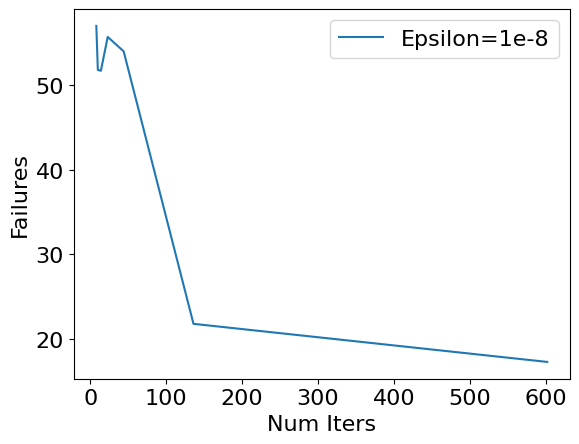

In [435]:
sns.lineplot(x='Num Iters', y='Failures', data=value_iterations[value_iterations['Epsilon'] == 1e-8], label='Epsilon=1e-8')

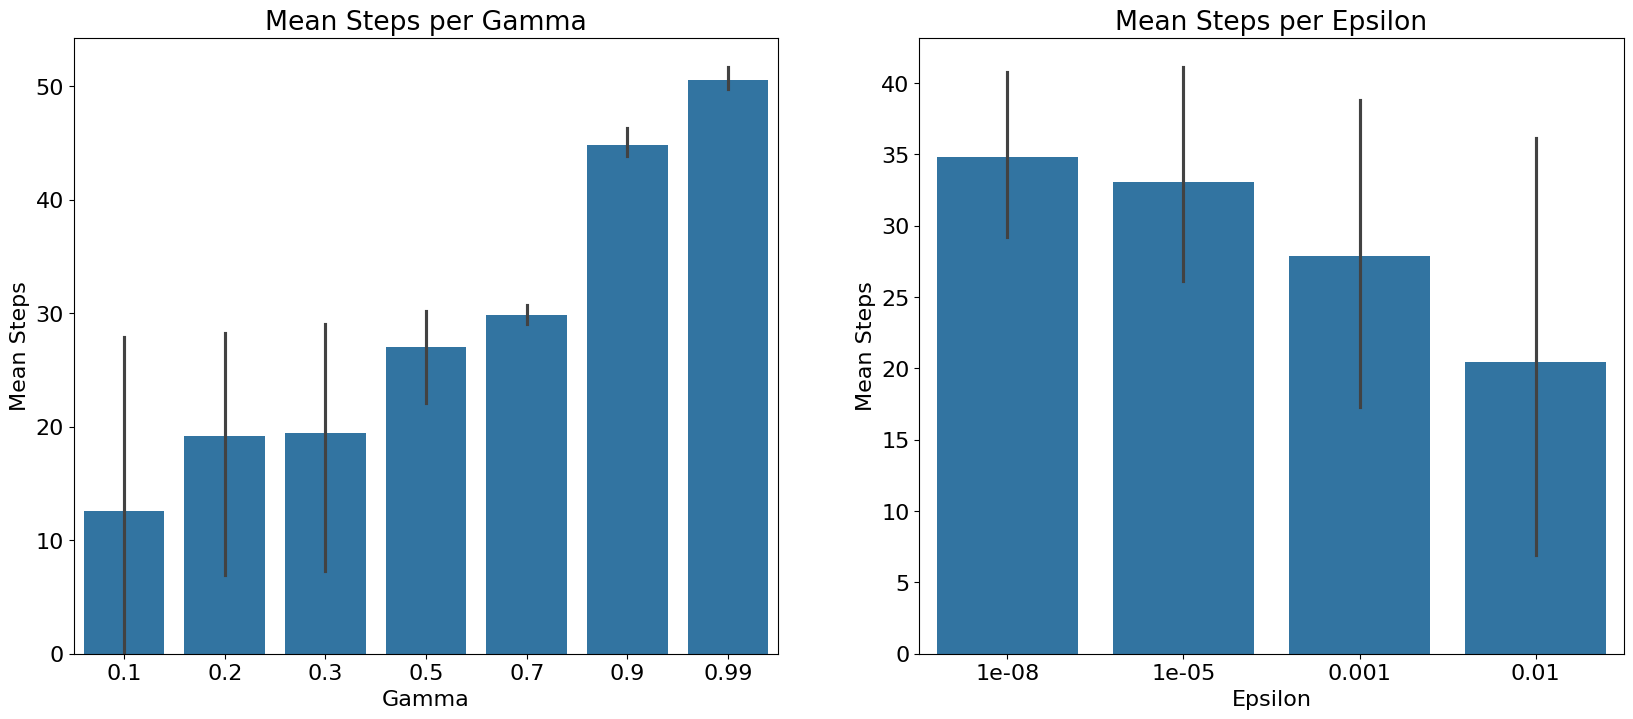

In [436]:
# Bar Plot of (Average Steps per gamma) in one subplot and (Average Steps per epsilon) in another subplot
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
sns.barplot(x='Gamma', y='Mean Steps', data=value_iterations, ax=ax[0])
ax[0].set_title('Mean Steps per Gamma')
sns.barplot(x='Epsilon', y='Mean Steps', data=value_iterations, ax=ax[1])
ax[1].set_title('Mean Steps per Epsilon')
plt.show()


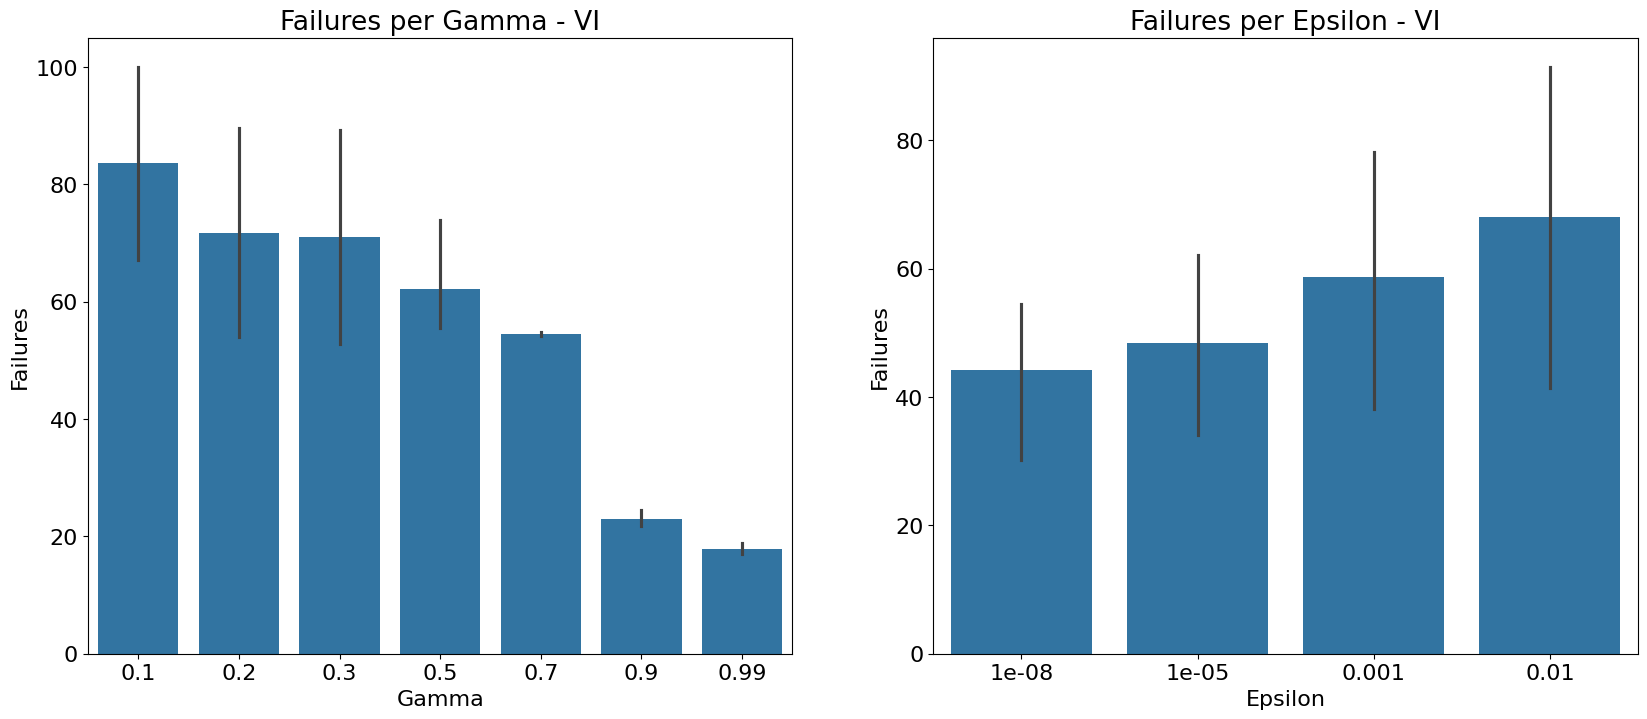

In [437]:
# Bar Plot of (Average Success percentage vs gamma) in one subplot and (Average Success percentage vs epsilon) in another subplot
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
sns.barplot(x='Gamma', y='Failures', data=value_iterations, ax=ax[0])
ax[0].set_title('Failures per Gamma - VI')
sns.barplot(x='Epsilon', y='Failures', data=value_iterations, ax=ax[1])
ax[1].set_title('Failures per Epsilon - VI')
plt.show()



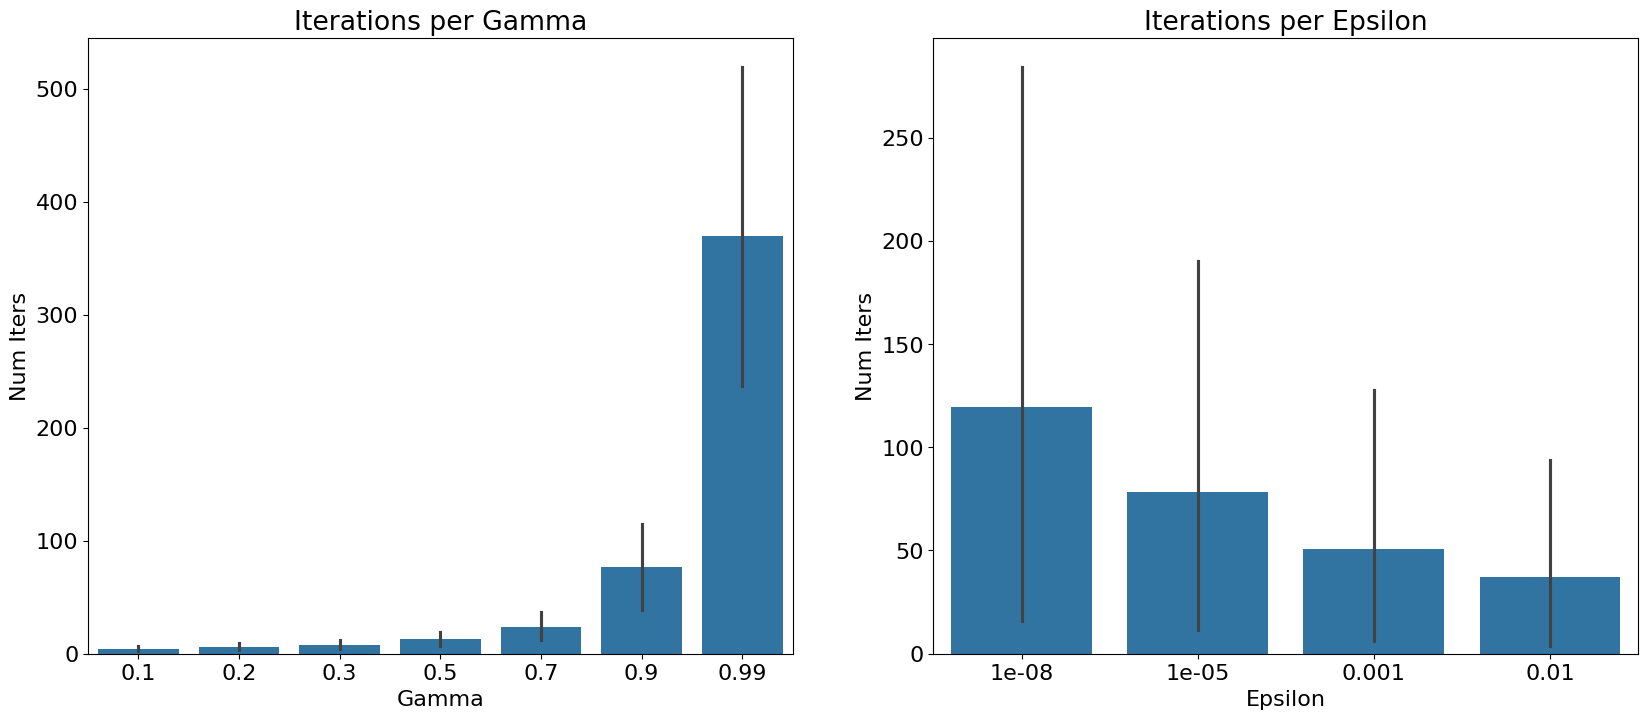

In [438]:
# Plot (Iterations vs Gamma) in one subplot and (Iterations vs Epsilon) in another subplot
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
sns.barplot(x='Gamma', y='Num Iters', data=value_iterations, ax=ax[0])
ax[0].set_title('Iterations per Gamma')
sns.barplot(x='Epsilon', y='Num Iters', data=value_iterations, ax=ax[1])
ax[1].set_title('Iterations per Epsilon')
plt.show()

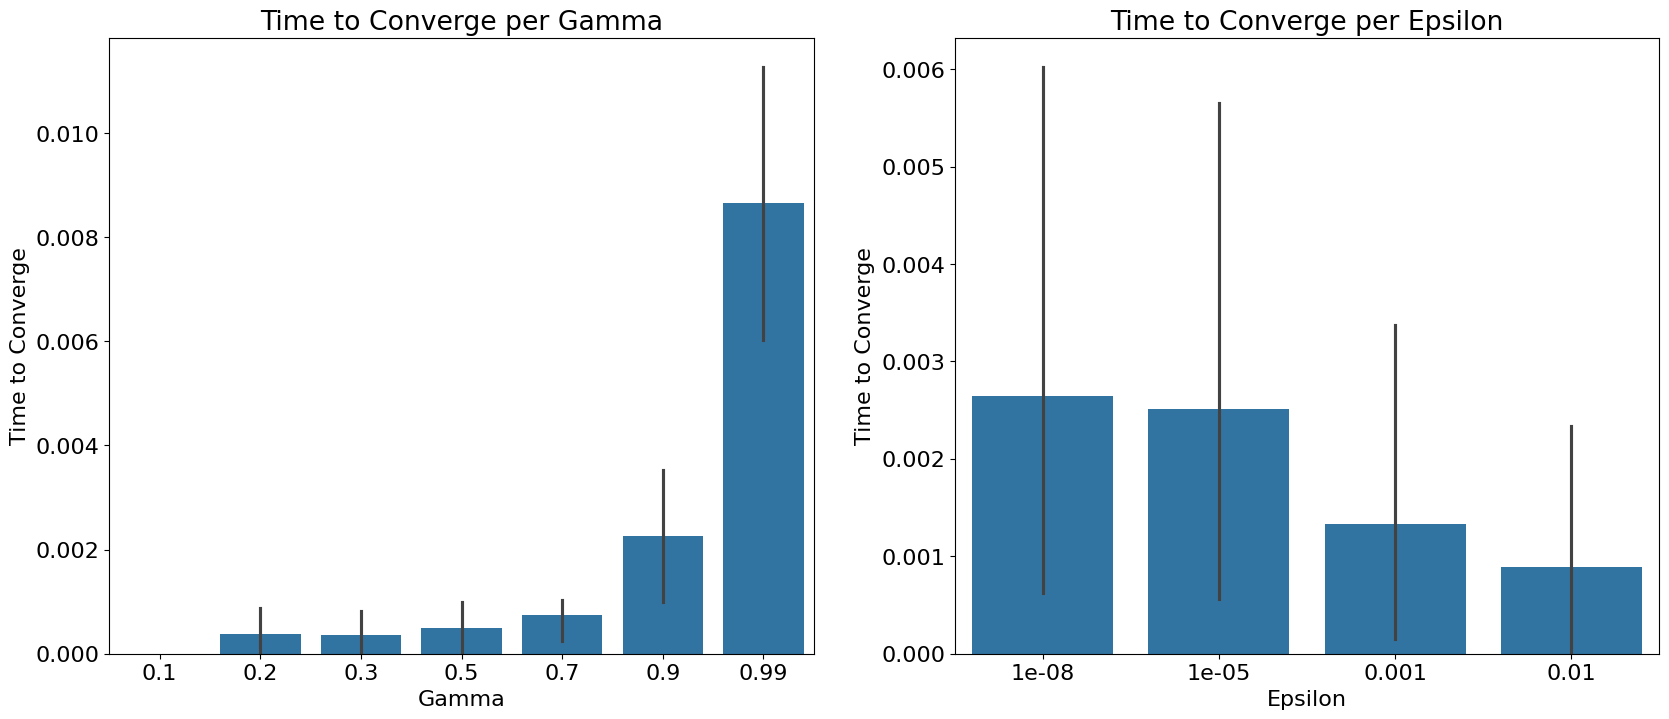

In [198]:
# Plot (convergence time vs Gamma) in one subplot and (convergence time vs Epsilon) in another subplot
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
sns.barplot(x='Gamma', y='Time to Converge', data=value_iterations, ax=ax[0])
ax[0].set_title('Time to Converge per Gamma')
sns.barplot(x='Epsilon', y='Time to Converge', data=value_iterations, ax=ax[1])
ax[1].set_title('Time to Converge per Epsilon')
plt.show()

In [199]:
# Number of Iterations vs time to converge

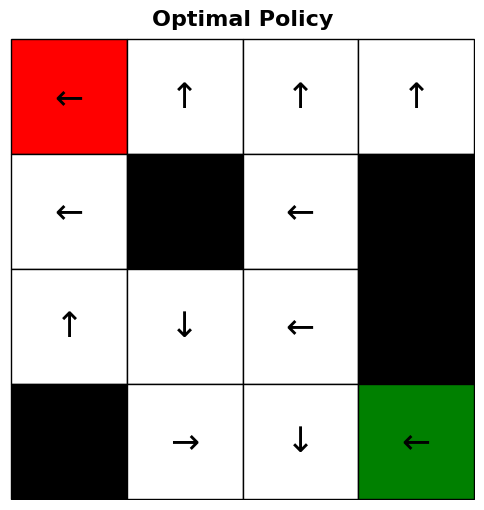

In [200]:
# Plot the optimal policy based on least failure percentage in grid with arrows
optimal_policy = value_iterations.loc[value_iterations['Failures'].idxmin(), 'Policy'].reshape((4, 4))
plot_lake(env, policy=optimal_policy, title='Optimal Policy')

## Experiment 2

In [439]:
def run_vi_exp_2(env, discount_factor, max_iterations=1000, epsilon=1e-8):
    # Experiments w.r.t different number of iterations
    V = np.zeros(env.observation_space.n)
    for i in range(max_iterations):
        #print (f"inner i {i}")
        prev_v = np.copy(V) 
        for state in range(env.observation_space.n):
            A = calculate_state_value_function(env, state, V, discount_factor)
            V[state] = np.max(A)
        if np.max(np.abs(V - prev_v)) < epsilon:
            break
    optimal_policy = np.zeros(env.observation_space.n, dtype=int)
    optimal_policy = update_policy(env, optimal_policy, V, discount_factor)
    
    return optimal_policy, V
            

In [440]:
discount_factors = [0.99, 0.9, 0.7, 0.5]
vi_iterations_results = []
iterations_range = range(10,1000,5)
optimal_policies = {}

for each_discount in discount_factors:
    print (each_discount)
    for iter in iterations_range:
        start_time = time.time()
        optimal_policy, V = run_vi_exp_2(env, each_discount, max_iterations=iter)
        env.reset()
        #print ("calculating rewards")
        wins, total_reward, avg_reward = run_episodes(env, 100, optimal_policy, random = False)
        end_time = time.time() - start_time
        vi_iterations_results.append([each_discount, iter, wins, total_reward, avg_reward, end_time])

vi_iterations_results_df = pd.DataFrame(vi_iterations_results, columns=['Discount Factor', 'Iterations','Wins', 'Total Reward', 'Average Reward', 'Time'])
vi_iterations_results_df.to_csv("vi_iterations_results_df_taxi_1.csv", index=False)
    
    


0.99
0.9
0.7
0.5


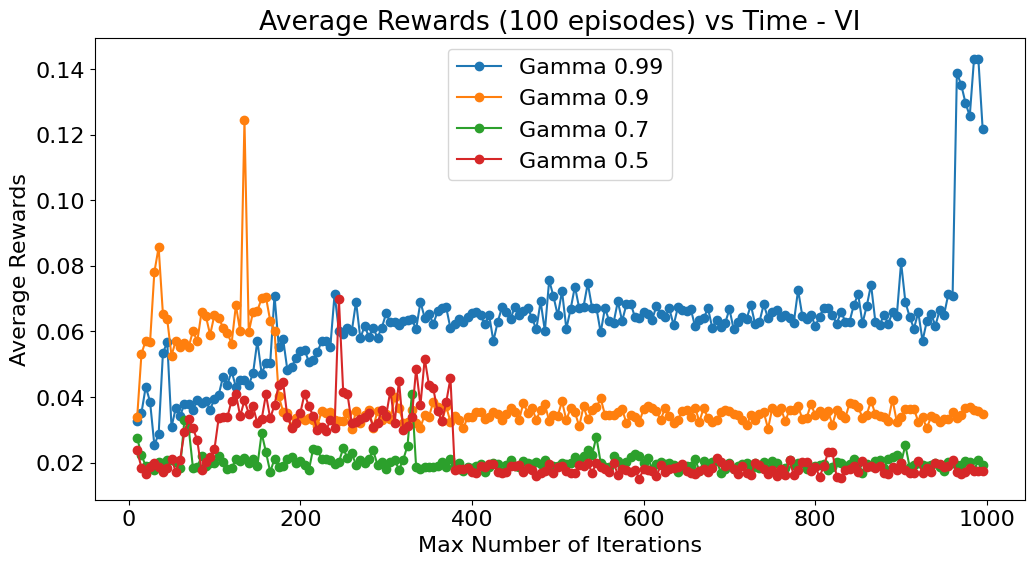

In [445]:
plt.plot(iterations_range,vi_iterations_results_df.loc[vi_iterations_results_df['Discount Factor']==0.99, "Time"],marker='o', label='Gamma 0.99')
plt.plot(iterations_range,vi_iterations_results_df.loc[vi_iterations_results_df['Discount Factor']==0.9, "Time"],marker='o', label='Gamma 0.9')
plt.plot(iterations_range,vi_iterations_results_df.loc[vi_iterations_results_df['Discount Factor']==0.7, "Time"],marker='o', label='Gamma 0.7')
plt.plot(iterations_range,vi_iterations_results_df.loc[vi_iterations_results_df['Discount Factor']==0.5, "Time"],marker='o', label='Gamma 0.5')

plt.xlabel('Max Number of Iterations')
plt.ylabel('Average Rewards')
plt.title('Average Rewards (100 episodes) vs Time - VI')
plt.legend()
fig=plt.gcf()
fig.set_size_inches(12,6)

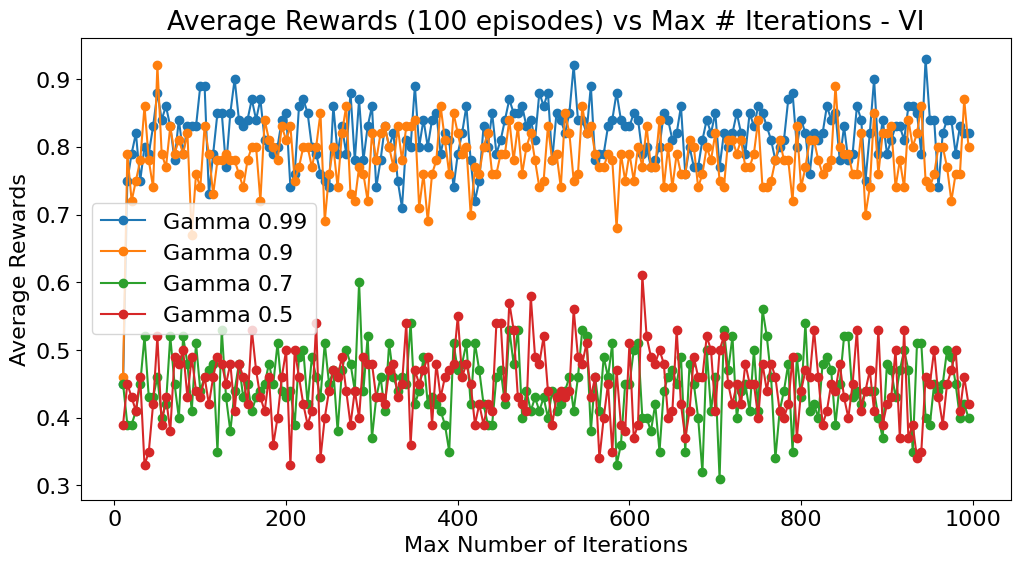

In [444]:
plt.plot(iterations_range,vi_iterations_results_df.loc[vi_iterations_results_df['Discount Factor']==0.99, "Average Reward"],marker='o', label='Gamma 0.99')
plt.plot(iterations_range,vi_iterations_results_df.loc[vi_iterations_results_df['Discount Factor']==0.9, "Average Reward"],marker='o', label='Gamma 0.9')
plt.plot(iterations_range,vi_iterations_results_df.loc[vi_iterations_results_df['Discount Factor']==0.7, "Average Reward"],marker='o', label='Gamma 0.7')
plt.plot(iterations_range,vi_iterations_results_df.loc[vi_iterations_results_df['Discount Factor']==0.5, "Average Reward"],marker='o', label='Gamma 0.5')

plt.xlabel('Max Number of Iterations')
plt.ylabel('Average Rewards')
plt.title('Average Rewards (100 episodes) vs Max # Iterations - VI')
plt.legend()
fig=plt.gcf()
fig.set_size_inches(12,6)

Text(0.5, 1.0, 'Average Rewards vs Discount Factors')

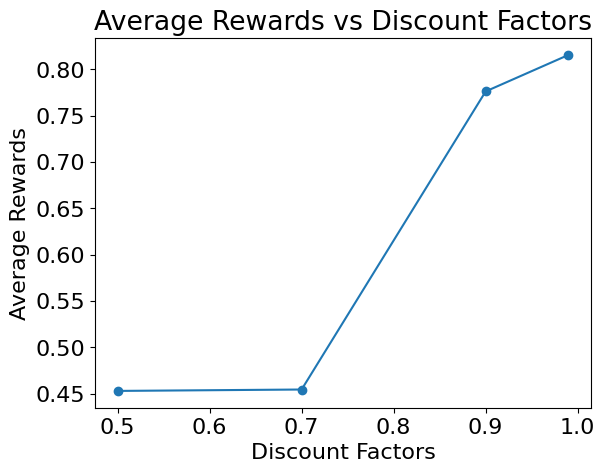

In [211]:
y = [vi_iterations_results_df.loc[vi_iterations_results_df['Discount Factor']==g, "Average Reward"].mean() for g in discount_factors]
plt.plot(discount_factors, y, marker='o')
plt.xlabel("Discount Factors")
plt.ylabel("Average Rewards")
plt.title("Average Rewards vs Discount Factors")

# Policy Iteration

In [411]:
def run_policy_iteration_exp(t, r, gamma_values, epsilons, max_iterations=100000):
    start_time = time.time()
    policy_iterations = []

    test_number = 0

    for gamma in gamma_values:
        
        vi = PolicyIteration(t, r, gamma, max_iter=max_iterations, eval_type="matrix")
        test_run = vi.run()

        max_reward = test_run[-1]['Reward'] # max reward
        time_to_converge = vi.time # time to converge
        num_iters = test_run[-1]['Iteration']  # number of iterations to converge
        reward = test_run[-1]['Max V'] # max V value

        # Collect mean V, max V and errors
        max_r, mean_r, errors = [], [], []
        for run in test_run:
            max_r.append(run['Max V'])
            mean_r.append(run['Mean V'])
            errors.append(run['Error'])

        policy = np.array(vi.policy)
        #policy
        #policy = policy.reshape((4,4))
        policy_iterations.append([gamma, max_reward, time_to_converge, 
                                    num_iters, reward, max(max_r), max(mean_r), max(errors), policy])
        test_number += 1
        end_time = time.time() - start_time

    #print ("Policy>>",policy)

    policy_iterations_df = pd.DataFrame(policy_iterations, columns=['Gamma', 'Max Reward', 'Time to Converge', 'Num Iters', 'Reward', 'Max V (All)', 'Mean V (All)', 'Errors', 'Policy'])
    #print('Time to converge: ', end_time)

    #print (value_iterations_df.head())
    
    # See differences in policy
    policies = policy_iterations_df['Policy']
    for i, policy in enumerate(policies):
        pol = np.array(policy)
        #print (pol)
        steps, steps_stddev, failures = get_number_of_steps(env, pol)
        policy_iterations_df.loc[i, 'Mean Steps'] = steps
        policy_iterations_df.loc[i, 'Std Steps'] = steps_stddev
        policy_iterations_df.loc[i, 'Failures'] = failures
    policy_iterations_df.fillna(0, inplace=True)
    return policy_iterations_df

In [412]:
# Changing value of Gamma
gamma_values = [0.1,0.2,0.3, 0.5,0.7, 0.9, 0.99]
epsilons = [1e-2, 1e-3, 1e-5, 1e-8]

# Define the transition probability matrix and reward matrix from the environment
P = construct_transition_matrix(env)
R = construct_reward_matrix(env)

policy_iterations = run_policy_iteration_exp(P, R, gamma_values, epsilons)
policy_iterations.to_csv('policy_iterations.csv', index=False)
policy_iterations.head()

C:\Users\vyassum\.pyenv\pyenv-win\versions\3.10.1\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


,Gamma,Max Reward,Time to Converge,Num Iters,Reward,Max V (All),Mean V (All),Errors,Policy,Mean Steps,Std Steps,Failures
0,0.1,1.035717,0.002024,4,1.035717,1.035717,0.069362,0.034483,"[1, 3, 2, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0]",29.738562,20.782861,54.1
1,0.2,1.076975,0.001000,4,1.076975,1.076975,0.077722,0.071429,"[1, 3, 2, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0]",28.261339,19.568751,53.7
2,0.3,1.125308,0.000997,4,1.125308,1.125308,0.088154,0.111111,"[1, 3, 2, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0]",29.662069,20.074535,56.5
3,0.5,1.253582,0.000996,4,1.253582,1.253582,0.119518,0.200000,"[1, 3, 2, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0]",30.199095,20.902731,55.8
4,0.7,1.461801,0.001019,4,1.461801,1.461801,0.183700,0.304348,"[1, 3, 2, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0]",29.537118,20.292720,54.2


In [275]:
policy_iterations

,Gamma,Max Reward,Time to Converge,Num Iters,Reward,Max V (All),Mean V (All),Errors,Policy,Mean Steps,Std Steps,Failures
0,0.10,1.035717,0.003257,4,1.035717,1.035717,0.069362,0.034483,"[1, 3, 2, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0]",28.006667,20.661450,55.0
1,0.20,1.076975,0.002278,4,1.076975,1.076975,0.077722,0.071429,"[1, 3, 2, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0]",30.157175,19.813605,56.1
2,0.30,1.125308,0.001995,4,1.125308,1.125308,0.088154,0.111111,"[1, 3, 2, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0]",27.950959,18.659551,53.1
3,0.50,1.253582,0.002007,4,1.253582,1.253582,0.119518,0.200000,"[1, 3, 2, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0]",29.289823,19.617190,54.8
4,0.70,1.461801,0.003999,4,1.461801,1.461801,0.183700,0.304348,"[1, 3, 2, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0]",30.121005,20.543227,56.2
5,0.90,1.917060,0.001620,6,1.917060,1.917060,0.408017,0.428571,"[0, 3, 0, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0]",43.476943,32.566287,24.1
6,0.99,2.588512,0.000000,7,2.588512,2.588512,1.188716,0.492537,"[0, 3, 3, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0]",49.411552,38.503649,16.9


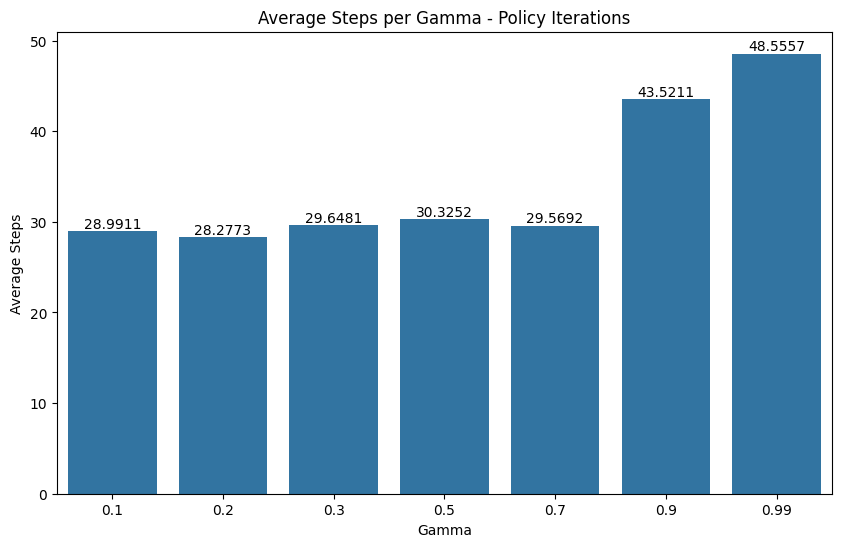

In [121]:
# Plot (Average steps taken vs Gamma)
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Gamma', y='Mean Steps', data=policy_iterations)
ax.bar_label(ax.containers[0], fontsize=10)
plt.title('Average Steps per Gamma - Policy Iterations')
plt.xlabel('Gamma')
plt.ylabel('Average Steps')
plt.show()

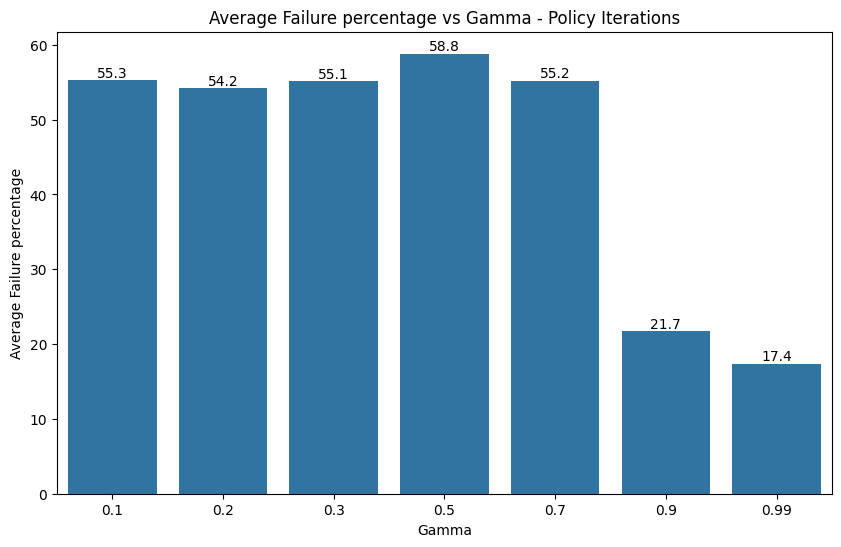

In [120]:
# Plot success vs gamma
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Gamma', y='Failures', data=policy_iterations)
ax.bar_label(ax.containers[0], fontsize=10)
plt.title('Average Failure percentage vs Gamma - Policy Iterations')
plt.xlabel('Gamma')
plt.ylabel('Average Failure percentage')
plt.show()

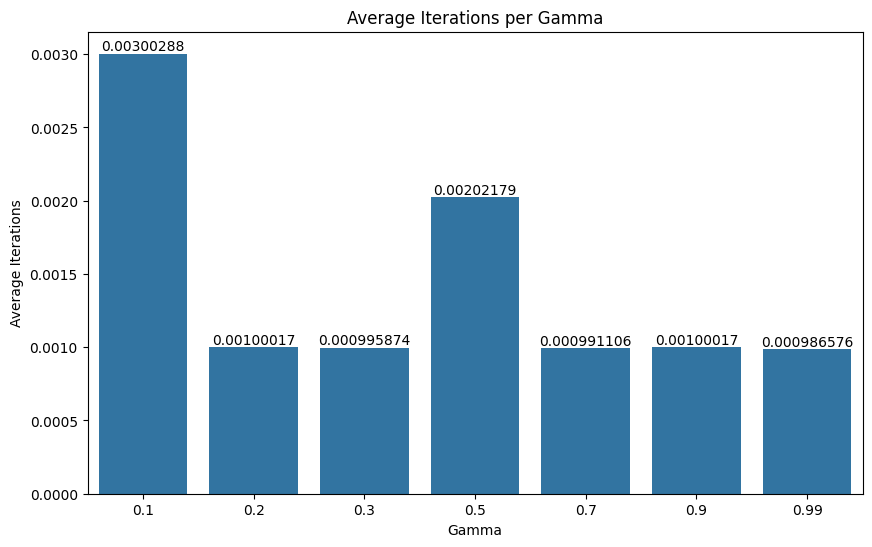

In [122]:
# PLot Iterations per gamma
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Gamma', y='Num Iters', data=policy_iterations)
ax.bar_label(ax.containers[0], fontsize=10)
plt.title('Average Iterations per Gamma')
plt.xlabel('Gamma')
plt.ylabel('Average Iterations')
plt.show()

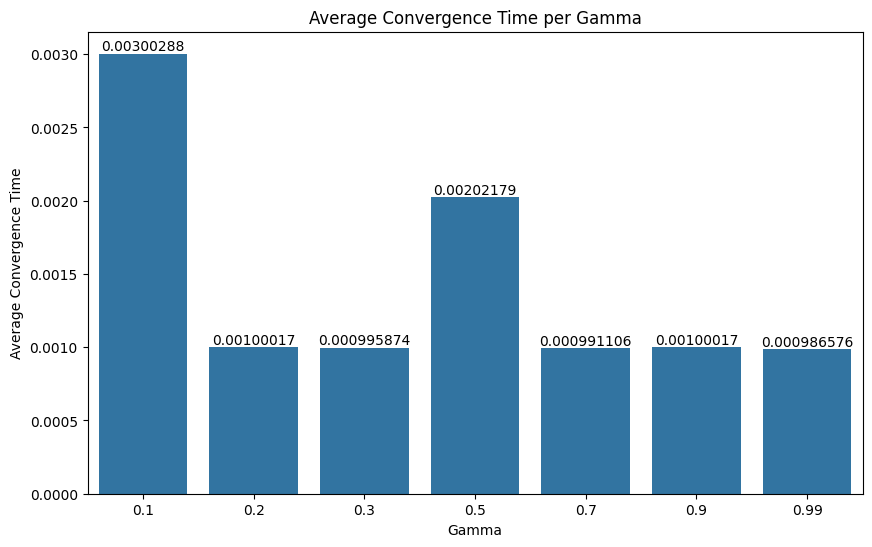

In [123]:
# plot convergence time vs gamma
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Gamma', y='Time to Converge', data=policy_iterations)
ax.bar_label(ax.containers[0], fontsize=10)
plt.title('Average Convergence Time per Gamma')
plt.xlabel('Gamma')
plt.ylabel('Average Convergence Time')
plt.show()

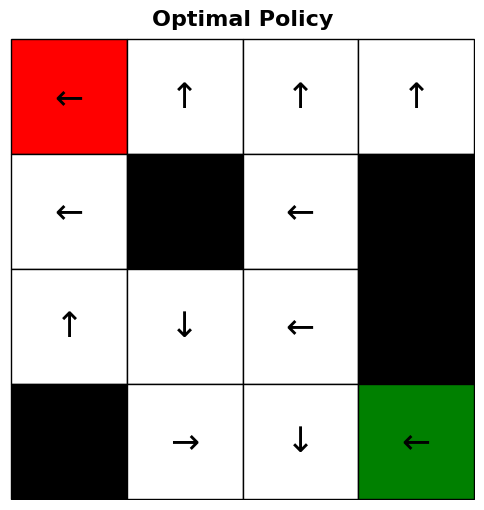

In [124]:
# Plot the optimal policy based on least failure percentage in grid with arrows
optimal_policy = policy_iterations.loc[policy_iterations['Failures'].idxmin(), 'Policy'].reshape((4, 4))
plot_lake(env, policy=optimal_policy, title='Optimal Policy')

# Experiment 2

In [356]:
def policy_eval(env, policy, V, discount_factor):
    policy_value = np.zeros(env.observation_space.n)
    for state in range(env.observation_space.n):
        action = policy[state]
        for prob, next_state, reward, info in env.P[state][action]:
            policy_value[state] += prob * (reward + discount_factor * V[next_state])
    return policy_value

def policy_iteration(env, discount_factor, max_iterations=1000):
    V = np.zeros(env.observation_space.n)
    policy = np.random.choice(env.action_space.n, env.observation_space.n)
    prev_policy = np.copy(policy)
    for i in range(max_iterations):
        
        V = policy_eval(env, policy, V, discount_factor)
        policy = update_policy(env, policy, V, discount_factor)
        if i % 10 == 0:
            if (np.all(np.equal(policy, prev_policy))):
               break
    return policy, V

In [357]:
discount_factors = [0.99, 0.9, 0.7, 0.5]
pi_iterations_results = []
iterations_range = range(10,1000,5)
optimal_policies = {}

for each_discount in discount_factors:
    print (each_discount)
    for iter in iterations_range:
        start_time = time.time()
        optimal_policy, V = policy_iteration(env, each_discount, max_iterations=iter)
        env.reset()
        #print ("calculating rewards")
        wins, total_reward, avg_reward = run_episodes(env, 100, optimal_policy, random = False)
        end_time = time.time() - start_time
        pi_iterations_results.append([each_discount, iter, wins, total_reward, avg_reward, end_time, V])

pi_iterations_results_df = pd.DataFrame(pi_iterations_results, columns=['Discount Factor', 'Iterations','Wins', 'Total Reward', 'Average Reward', 'Time', 'V'])
pi_iterations_results_df.to_csv("pi_iterations_results_df_taxi_1.csv", index=False)



0.99
0.9
0.7
0.5


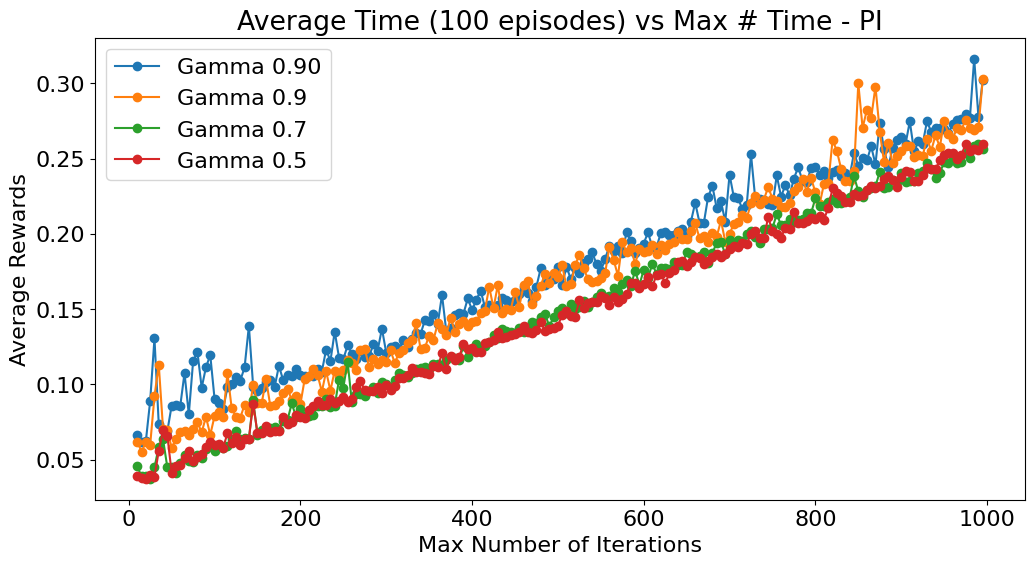

In [447]:
plt.plot(iterations_range,pi_iterations_results_df.loc[pi_iterations_results_df['Discount Factor']==0.99, "Time"],marker='o', label='Gamma 0.90')
plt.plot(iterations_range,pi_iterations_results_df.loc[pi_iterations_results_df['Discount Factor']==0.9, "Time"],marker='o', label='Gamma 0.9')
plt.plot(iterations_range,pi_iterations_results_df.loc[pi_iterations_results_df['Discount Factor']==0.7, "Time"],marker='o', label='Gamma 0.7')
plt.plot(iterations_range,pi_iterations_results_df.loc[pi_iterations_results_df['Discount Factor']==0.5, "Time"],marker='o', label='Gamma 0.5')

plt.xlabel('Max Number of Iterations')
plt.ylabel('Average Rewards')
plt.title('Average Time (100 episodes) vs Max # Time - PI')
plt.legend()
fig=plt.gcf()
fig.set_size_inches(12,6)

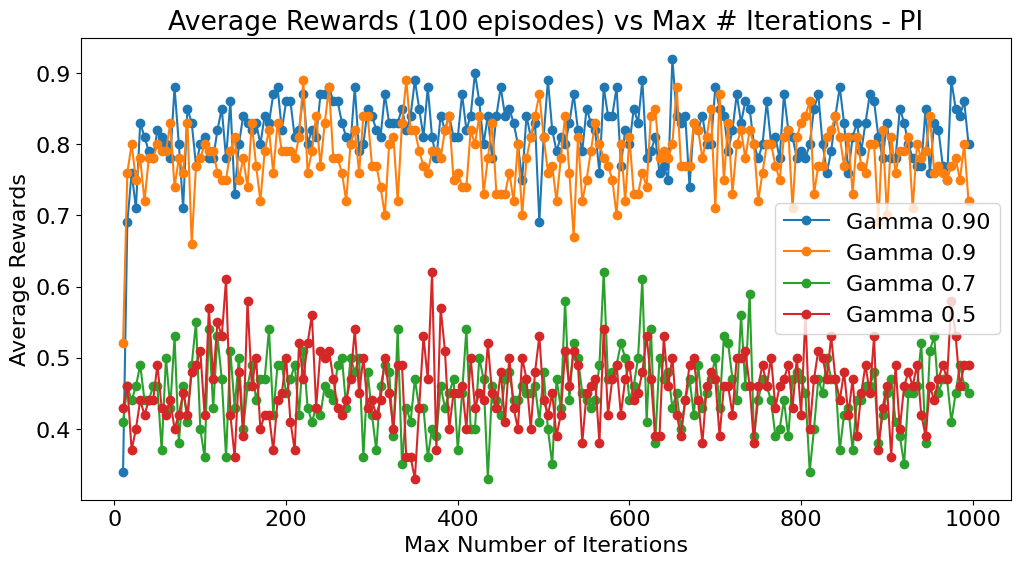

In [448]:
plt.plot(iterations_range,pi_iterations_results_df.loc[pi_iterations_results_df['Discount Factor']==0.99, "Average Reward"],marker='o', label='Gamma 0.90')
plt.plot(iterations_range,pi_iterations_results_df.loc[pi_iterations_results_df['Discount Factor']==0.9, "Average Reward"],marker='o', label='Gamma 0.9')
plt.plot(iterations_range,pi_iterations_results_df.loc[pi_iterations_results_df['Discount Factor']==0.7, "Average Reward"],marker='o', label='Gamma 0.7')
plt.plot(iterations_range,pi_iterations_results_df.loc[pi_iterations_results_df['Discount Factor']==0.5, "Average Reward"],marker='o', label='Gamma 0.5')

plt.xlabel('Max Number of Iterations')
plt.ylabel('Average Rewards')
plt.title('Average Rewards (100 episodes) vs Max # Iterations - PI')
plt.legend()
fig=plt.gcf()
fig.set_size_inches(12,6)

Text(0.5, 1.0, 'Average Rewards vs Discount Factors')

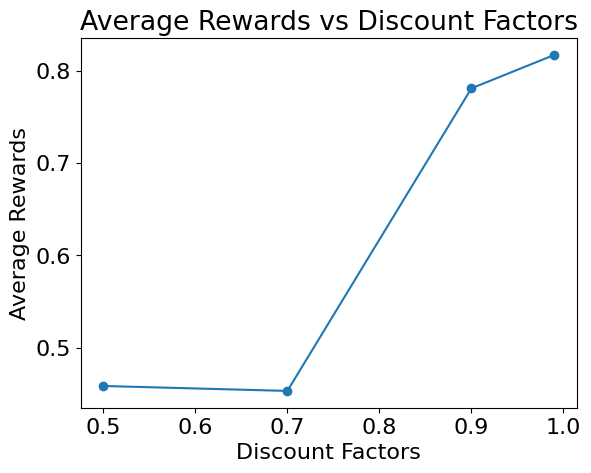

In [363]:
y = [pi_iterations_results_df.loc[pi_iterations_results_df['Discount Factor']==g, "Average Reward"].mean() for g in discount_factors]
plt.plot(discount_factors, y, marker='o')
plt.xlabel("Discount Factors")
plt.ylabel("Average Rewards")
plt.title("Average Rewards vs Discount Factors")

# Q-Learning Experiment

In [545]:
def run_q_learning_exp(t, r, gammas, alphas, alpha_decays, epsilon_decays, max_iterations=10000):
    start_time = time.time()
    q_learning_iterations = []

    test_number = 0

    for gamma in gammas:
        for alpha in alphas:
            for alpha_decay in alpha_decays:
                for epsilon_decay in epsilon_decays:
                    print (gamma, alpha, alpha_decay, epsilon_decay)
                    ql = QLearning(t, r, gamma, alpha, alpha_decay, epsilon_decay, n_iter=max_iterations)
                    test_run = ql.run()

                    max_reward = test_run[-1]['Reward'] # max reward
                    time_to_converge = test_run[-1]['Time'] # time to converge
                    num_iters = test_run[-1]['Iteration'] # number of iterations to converge
                    reward = test_run[-1]['Max V'] # max V value

                    # Collect mean V, max V and errors
                    max_r, mean_r, errors = [], [], []
                    for run in test_run:
                        max_r.append(run['Max V'])
                        mean_r.append(run['Mean V'])
                        errors.append(run['Error'])

                    policy = np.array(ql.policy)
                    #policy
                    #policy = policy.reshape((4,4))
                    q_learning_iterations.append([gamma, alpha, alpha_decay, epsilon_decay, max_reward, time_to_converge, 
                                                num_iters, reward, max(max_r), max(mean_r), max(errors), policy])
                    test_number += 1
                    end_time = time.time() - start_time

    #print ("Policy>>",policy)

    q_learning_iterations_df = pd.DataFrame(q_learning_iterations, columns=['Gamma', 'Alpha', 'Alpha Decay', 'Epsilon Decay', 'Max Reward', 'Time to Converge', 'Num Iters', 'Reward', 'Max V (All)', 'Mean V (All)', 'Errors', 'Policy'])
    #print('Time to converge: ', end_time)

    #print (value_iterations_df.head())
    
    # See differences in policy
    policies = q_learning_iterations_df['Policy']
    for i, policy in enumerate(policies):
        print (i)
        pol = np.array(policy)
        #print (pol)
        steps, steps_stddev, failures = get_number_of_steps(env, pol)
        q_learning_iterations_df.loc[i, 'Mean Steps'] = steps
        q_learning_iterations_df.loc[i, 'Std Steps'] = steps_stddev
        q_learning_iterations_df.loc[i, 'Failures'] = failures
    q_learning_iterations_df.fillna(0, inplace=True)
    return q_learning_iterations_df

In [546]:
# Changing value of Gamma
gamma_values = [0.1, 0.5,0.9]
alphas = [0.01,0.05,0.5,0.9]
alpha_decays = [0.5, 0.9, 0.99]
epsilons = [1e-5, 1e-6, 1e-7, 1e-8]

# Define the transition probability matrix and reward matrix from the environment
P = construct_transition_matrix(env)
R = construct_reward_matrix(env)

q_learning_iterations = run_q_learning_exp(P, R, gamma_values, alphas, alpha_decays, epsilons)
q_learning_iterations.to_csv('q_learning_iterations.csv', index=False)
q_learning_iterations.head()

0.1 0.01 0.5 1e-05
0.1 0.01 0.5 1e-06
0.1 0.01 0.5 1e-07
0.1 0.01 0.5 1e-08
0.1 0.01 0.9 1e-05
0.1 0.01 0.9 1e-06
0.1 0.01 0.9 1e-07
0.1 0.01 0.9 1e-08
0.1 0.01 0.99 1e-05
0.1 0.01 0.99 1e-06
0.1 0.01 0.99 1e-07
0.1 0.01 0.99 1e-08
0.1 0.05 0.5 1e-05
0.1 0.05 0.5 1e-06
0.1 0.05 0.5 1e-07
0.1 0.05 0.5 1e-08
0.1 0.05 0.9 1e-05
0.1 0.05 0.9 1e-06
0.1 0.05 0.9 1e-07
0.1 0.05 0.9 1e-08
0.1 0.05 0.99 1e-05
0.1 0.05 0.99 1e-06
0.1 0.05 0.99 1e-07
0.1 0.05 0.99 1e-08
0.1 0.5 0.5 1e-05
0.1 0.5 0.5 1e-06
0.1 0.5 0.5 1e-07
0.1 0.5 0.5 1e-08
0.1 0.5 0.9 1e-05
0.1 0.5 0.9 1e-06
0.1 0.5 0.9 1e-07
0.1 0.5 0.9 1e-08
0.1 0.5 0.99 1e-05
0.1 0.5 0.99 1e-06
0.1 0.5 0.99 1e-07
0.1 0.5 0.99 1e-08
0.1 0.9 0.5 1e-05
0.1 0.9 0.5 1e-06
0.1 0.9 0.5 1e-07
0.1 0.9 0.5 1e-08
0.1 0.9 0.9 1e-05
0.1 0.9 0.9 1e-06
0.1 0.9 0.9 1e-07
0.1 0.9 0.9 1e-08
0.1 0.9 0.99 1e-05
0.1 0.9 0.99 1e-06
0.1 0.9 0.99 1e-07
0.1 0.9 0.99 1e-08
0.5 0.01 0.5 1e-05
0.5 0.01 0.5 1e-06
0.5 0.01 0.5 1e-07
0.5 0.01 0.5 1e-08
0.5 0.01 0.9 1e-05
0

KeyboardInterrupt: 

In [ ]:
# Run value iteration and policy iteration
vi_values = []
pi_values = []
iterations_range_conv = range(1, 100)

for i in iterations_range_conv:  # Iterate for 100 iterations
    opt_policy, vi_V = run_vi_exp_2(env, 0.3, max_iterations=1000)
    opt_policy, pi_V = policy_iteration(env, 0.3, max_iterations=1000)
    vi_values.append(vi_V)
    pi_values.append(pi_V)

In [ ]:
q_learning_iterations.Failures.value_counts()

Failures
100.0    131
91.3       1
98.2       1
93.8       1
87.1       1
96.0       1
93.4       1
75.0       1
83.1       1
96.1       1
88.4       1
88.0       1
88.7       1
96.3       1
Name: count, dtype: int64

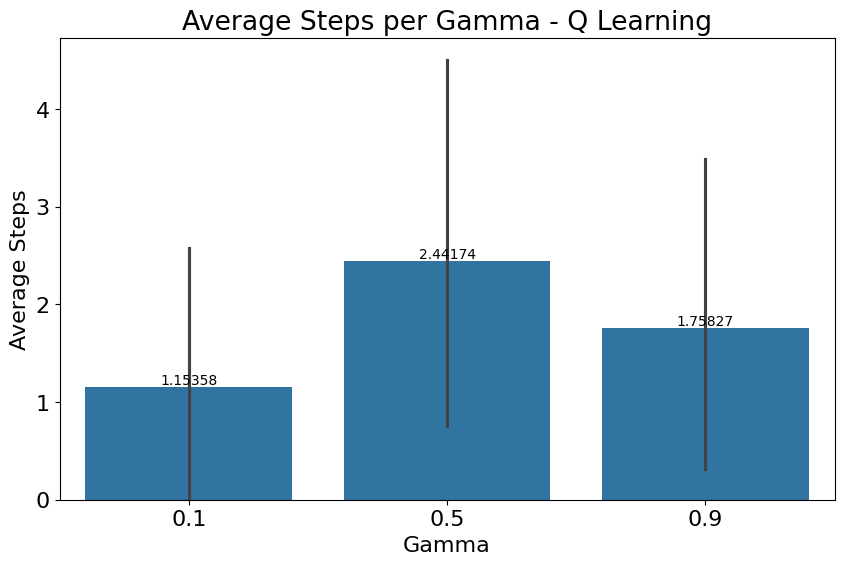

In [ ]:
# Plot Mean time taken to reach goal vs Gamma
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Gamma', y='Mean Steps', data=q_learning_iterations)
ax.bar_label(ax.containers[0], fontsize=10)
plt.title('Average Steps per Gamma - Q Learning')
plt.xlabel('Gamma')
plt.ylabel('Average Steps')
plt.show()

In [ ]:
# Plot Time to converge vs number of Iterations
plt.figure(figsize=(10, 6))




<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

## Experiment 2

In [ ]:
def implement_q_learning(discount_factor, decay, alpha):
    # Capture rewards over multiple episodes
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    train_episodes = 10000
    max_steps = 100
    max_epsilon, min_epsilon = 1, 0.01
    epsilon = 1
    training_rewards, training_times = [], []
    init_time = time.time()

    env.reset()

    for each_episode in range(train_episodes):
        state = env.reset()[0]
        total_reward = 0
        for step in range(max_steps):
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[state, :])
            next_state, reward, done, info, _ = env.step(action)
            Q[state, action] = Q[state, action] + alpha * (reward + discount_factor * np.max(Q[next_state, :]) - Q[state, action])
            total_reward += reward
            state = next_state
            if done:
                break
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay * each_episode)
        training_rewards.append(total_reward)
        training_times.append(time.time() - init_time)
    return training_rewards, training_times, Q


# Gamma

0.99
0.9
0.7
0.5


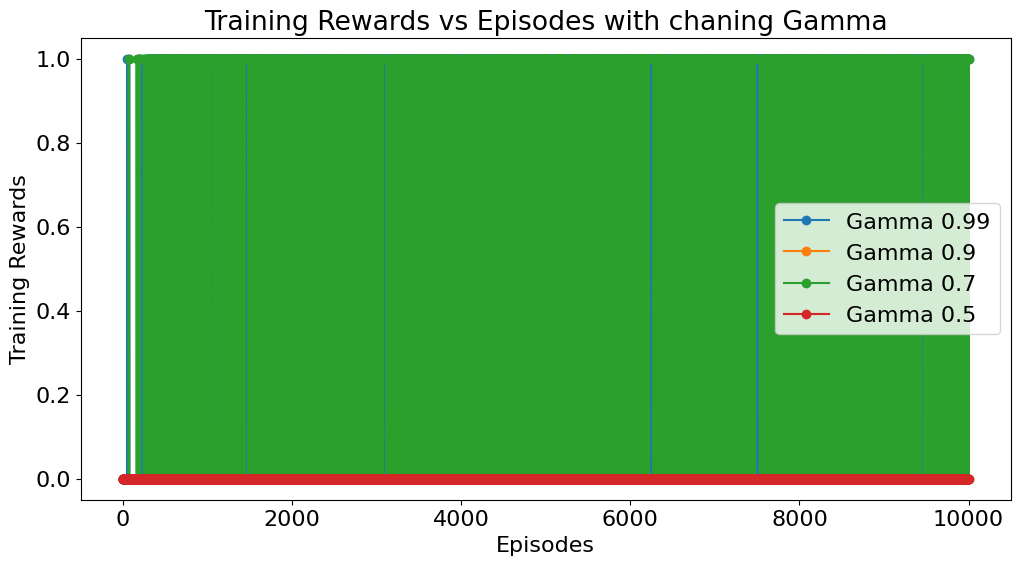

In [ ]:
gamma_values = [0.99, 0.9, 0.7, 0.5]
for each_gamma in gamma_values:
    print (each_gamma)
    training_rewards, training_times, Q = implement_q_learning(discount_factor=each_gamma, decay=0.01, alpha=0.7)
    plt.plot(training_rewards, label=f"Gamma {each_gamma}", marker='o')
plt.xlabel('Episodes')
plt.ylabel('Training Rewards')
plt.title('Training Rewards vs Episodes with chaning Gamma')
plt.legend()
fig=plt.gcf()
fig.set_size_inches(12,6)

0.99
0.9
0.7
0.5


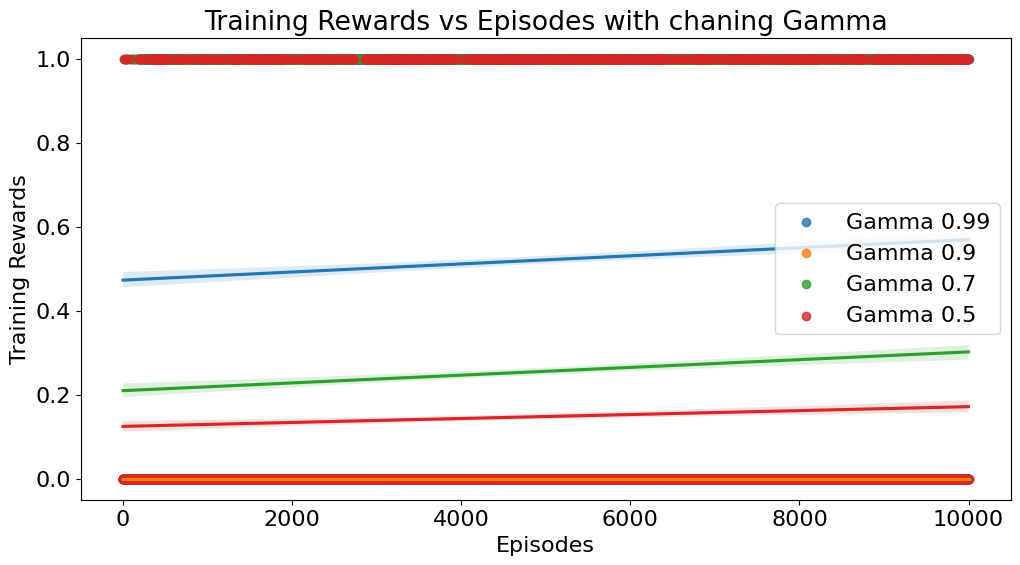

In [ ]:
gamma_values = [0.99, 0.9, 0.7, 0.5]
for each_gamma in gamma_values:
    print (each_gamma)
    training_rewards, training_times, Q = implement_q_learning(discount_factor=each_gamma, decay=0.01, alpha=0.7)
    sns.regplot(x=np.array(range(len(training_rewards))), y=training_rewards, label=f"Gamma {each_gamma}", marker='o')
plt.xlabel('Episodes')
plt.ylabel('Training Rewards')
plt.title('Training Rewards vs Episodes with chaning Gamma')
plt.legend()
fig=plt.gcf()
fig.set_size_inches(12,6)

# Alpha

0.9
0.7
0.5
0.3
0.1


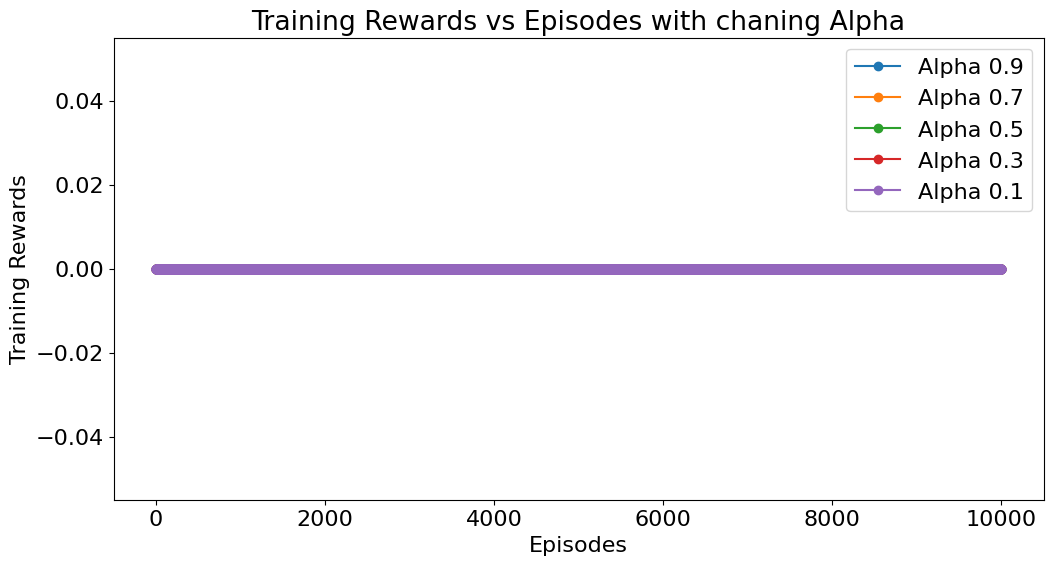

In [ ]:
# Plotting for different alpha values
alpha_values = [0.9, 0.7, 0.5, 0.3, 0.1]
for each_alpha in alpha_values:
    print (each_alpha)
    training_rewards, training_times, Q = implement_q_learning(discount_factor=0.9, decay=0.01, alpha=each_alpha)
    plt.plot(training_rewards, label=f"Alpha {each_alpha}", marker='o')
plt.xlabel('Episodes')
plt.ylabel('Training Rewards')
plt.title('Training Rewards vs Episodes with chaning Alpha')
plt.legend()
fig=plt.gcf()
fig.set_size_inches(12,6)

0.9
0.7
0.5
0.3
0.1


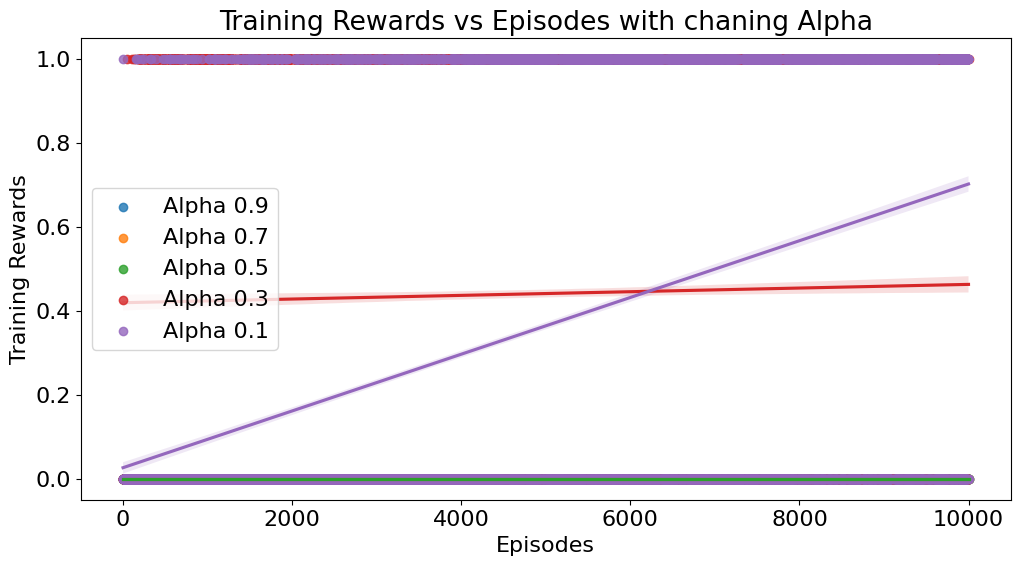

In [ ]:
# Plotting for different alpha values
alpha_values = [0.9, 0.7, 0.5, 0.3, 0.1]
for each_alpha in alpha_values:
    print (each_alpha)
    training_rewards, training_times, Q = implement_q_learning(discount_factor=0.9, decay=0.01, alpha=each_alpha)
    sns.regplot(x=np.array(range(len(training_rewards))), y=training_rewards, label=f"Alpha {each_alpha}", marker='o')
plt.xlabel('Episodes')
plt.ylabel('Training Rewards')
plt.title('Training Rewards vs Episodes with chaning Alpha')
plt.legend()
fig=plt.gcf()
fig.set_size_inches(12,6)

# Decay

0.99
0.5
0.09
0.01


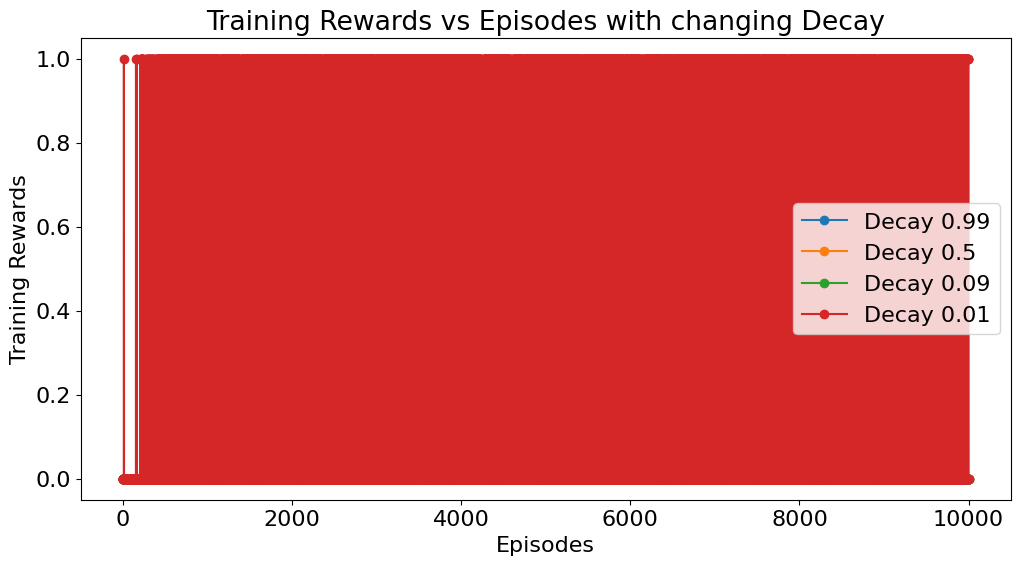

In [ ]:
# Plotting for different decay values
decay_values = [0.99, 0.5, 0.09, 0.01]
for each_decay in decay_values:
    print (each_decay)
    training_rewards, training_times, Q = implement_q_learning(discount_factor=0.9, decay=each_decay, alpha=0.7)
    plt.plot(training_rewards, label=f"Decay {each_decay}", marker='o')
    
plt.xlabel('Episodes')
plt.ylabel('Training Rewards')
plt.title('Training Rewards vs Episodes with changing Decay')
plt.legend()
fig=plt.gcf()
fig.set_size_inches(12,6)


0.99
0.5
0.09
0.01


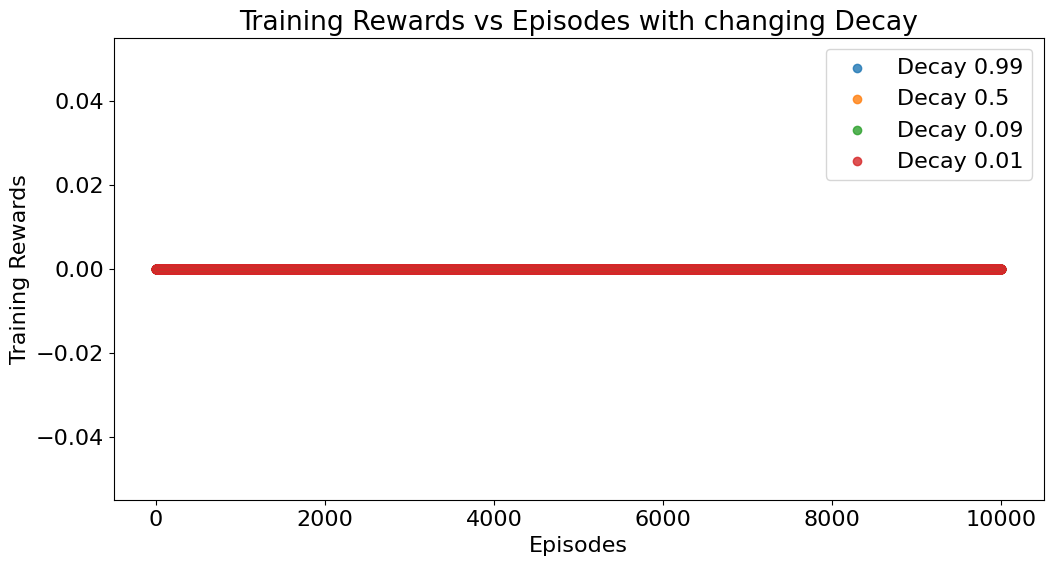

In [ ]:
# Plotting for different decay values
decay_values = [0.99, 0.5, 0.09, 0.01]
for each_decay in decay_values:
    print (each_decay)
    training_rewards, training_times, Q = implement_q_learning(discount_factor=0.9, decay=each_decay, alpha=0.7)
    sns.regplot(x=np.array(range(len(training_rewards))), y=training_rewards, label=f"Decay {each_decay}", marker='o')
plt.xlabel('Episodes')
plt.ylabel('Training Rewards')
plt.title('Training Rewards vs Episodes with changing Decay')
plt.legend()
fig=plt.gcf()
fig.set_size_inches(12,6)


In [ ]:
#q_learning_iterations[]


condition = ((q_learning_iterations['Gamma'] == 0.9) & (q_learning_iterations['Alpha'] == 0.9) & (q_learning_iterations['Alpha Decay'] == 0.9) & (q_learning_iterations['Epsilon Decay'] == 1e-5))



In [ ]:
q_learning_iterations["Num Iters"].value_counts()

Num Iters
10000    144
Name: count, dtype: int64

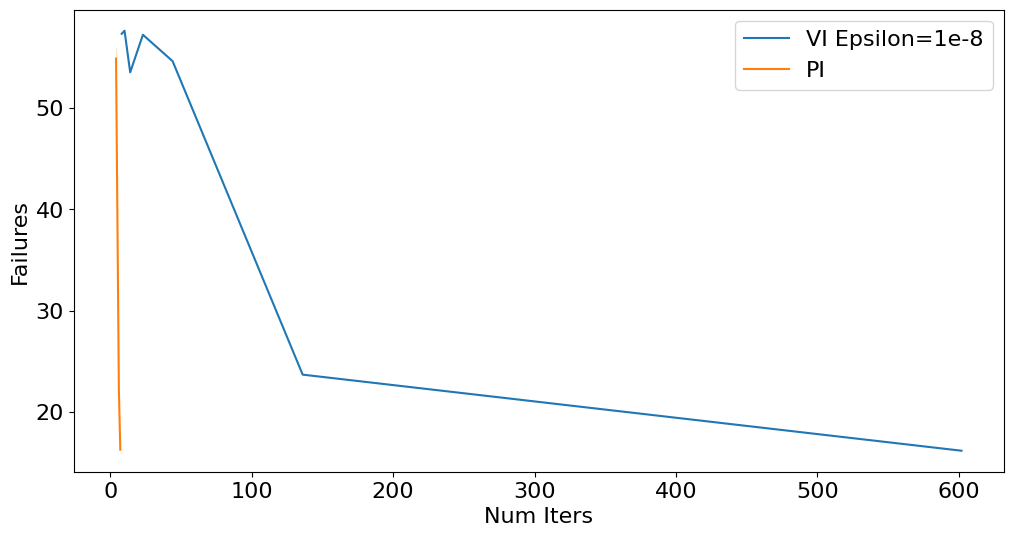

In [413]:
sns.lineplot(x='Num Iters', y='Failures', data=value_iterations[value_iterations['Epsilon'] == 1e-8], label='VI Epsilon=1e-8')
sns.lineplot(x='Num Iters', y='Failures', data=policy_iterations, label="PI")
plt.legend()
#sns.lineplot(x='Num Iters', y='Failures', data=q_learning_iterations_df)
fig=plt.gcf()
fig.set_size_inches(12,6)

In [ ]:
q_learning_iterations.head()

,Gamma,Alpha,Alpha Decay,Epsilon Decay,Max Reward,Time to Converge,Num Iters,Reward,Max V (All),Mean V (All),Errors,Policy
0,0.1,0.01,0.50,1.000000e-05,-1.0,1.038214,10000,0.002400,0.002400,0.000000e+00,0.100000,"[1, 0, 1, 1, 1, 1, 1, 1, 0, 2, 1, 3, 1, 2, 0, ..."
1,0.1,0.01,0.50,1.000000e-06,-1.0,0.999906,10000,0.000260,0.000260,0.000000e+00,0.100000,"[1, 0, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, ..."
2,0.1,0.01,0.50,1.000000e-07,-1.0,0.994434,10000,0.000024,0.000024,1.400000e-09,0.100000,"[3, 2, 1, 1, 1, 1, 1, 3, 1, 0, 1, 2, 2, 3, 1, ..."
3,0.1,0.01,0.50,1.000000e-08,-1.0,1.003598,10000,0.000003,0.000003,2.400000e-10,0.100000,"[1, 4, 0, 2, 1, 1, 3, 0, 2, 1, 1, 1, 1, 3, 1, ..."
4,0.1,0.01,0.90,1.000000e-05,-1.0,1.057180,10000,0.002400,0.002400,0.000000e+00,0.081000,"[2, 0, 1, 0, 0, 0, 1, 1, 0, 1, 2, 2, 2, 3, 2, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.9,0.90,0.90,1.000000e-08,-1.0,0.969769,10000,9.601440,9.601440,1.913188e-02,9.565938,"[3, 0, 0, 3, 2, 1, 1, 3, 1, 1, 0, 0, 1, 3, 1, ..."
296,0.9,0.90,0.99,1.000000e-05,20.0,1.025116,10000,0.019357,0.019357,0.000000e+00,8.910000,"[3, 3, 1, 0, 1, 1, 2, 0, 1, 2, 1, 1, 1, 1, 2, ..."
297,0.9,0.90,0.99,1.000000e-06,-1.0,1.009871,10000,0.000255,0.000255,0.000000e+00,9.000000,"[4, 4, 0, 2, 1, 0, 0, 1, 0, 1, 1, 1, 3, 2, 3, ..."
298,0.9,0.90,0.99,1.000000e-07,-1.0,1.000887,10000,4.026396,4.026396,3.910828e-03,8.820900,"[4, 3, 3, 1, 1, 3, 0, 3, 1, 1, 3, 1, 0, 1, 1, ..."


In [ ]:
optimal_policy = q_learning_iterations.loc[q_learning_iterations['Failures'].idxmin(), 'Policy'].reshape((4, 4))
plot_lake(env, policy=optimal_policy, title='Optimal Policy')

KeyError: 'Failures'

In [354]:
# Run value iteration and policy iteration
vi_values = []
pi_values = []
iterations_range_conv = range(1, 100)

for i in iterations_range_conv:  # Iterate for 100 iterations
    opt_policy, vi_V = run_vi_exp_2(env, 0.3, max_iterations=1000)
    opt_policy, pi_V = policy_iteration(env, 0.3, max_iterations=1000)
    vi_values.append(vi_V)
    pi_values.append(pi_V)

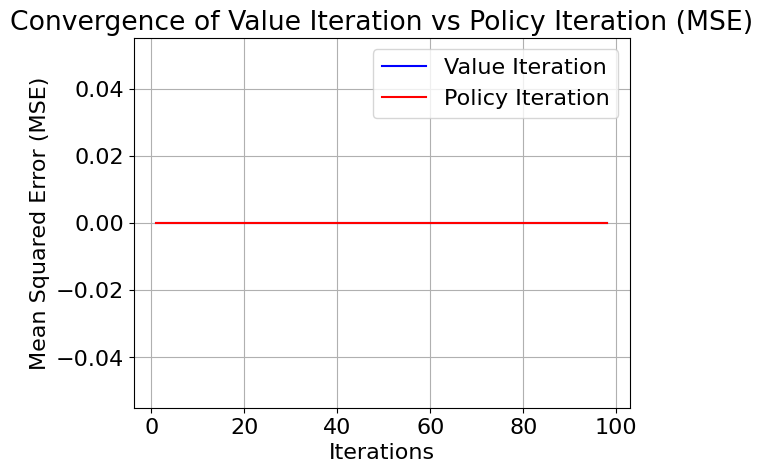

In [355]:
# Calculate Mean Squared Error (MSE) between successive value functions
vi_mse = [np.mean((vi_values[i] - vi_values[i-1])**2) for i in range(1, len(vi_values))]
pi_mse = [np.mean((pi_values[i] - pi_values[i-1])**2) for i in range(1, len(pi_values))]

# Plot the convergence graph
iterations_range_conv = list(range(1, 100))[:-1]  # One less because we calculate MSE
plt.plot(iterations_range_conv, vi_mse, label='Value Iteration', color='blue')
plt.plot(iterations_range_conv, pi_mse, label='Policy Iteration', color='red')
plt.xlabel('Iterations')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Convergence of Value Iteration vs Policy Iteration (MSE)')
plt.legend()
plt.grid(True)
plt.show()

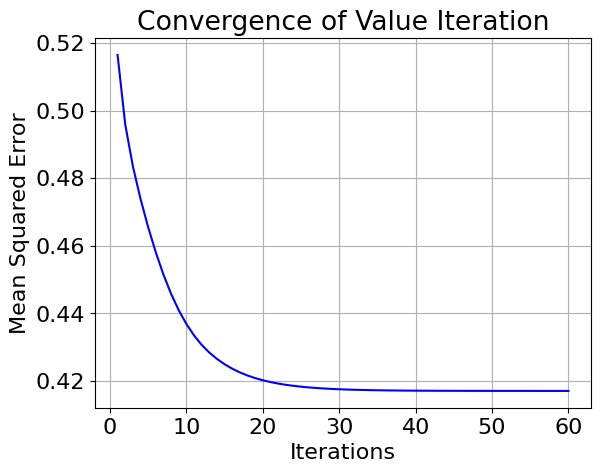

In [366]:
import gym
import numpy as np
import matplotlib.pyplot as plt

# Define the FrozenLake environment
env = gym.make("FrozenLake-v1")

# Optimal Value Function (if known)
# For FrozenLake, we can manually construct the optimal value function
optimal_V = np.array([0.75, 0.80, 0.82, 0.84, 0.88, 0., 0.88, 0.92, 0.96, 0., 0.96, 1., 0., 0., 1., 0.])

# Value Iteration algorithm
def value_iteration(env, gamma=0.9, epsilon=1e-6):
    num_states = env.observation_space.n
    num_actions = env.action_space.n

    # Initialize value function
    V = np.zeros(num_states)

    # Track squared errors over iterations
    squared_errors = []

    # Perform value iteration
    num_iterations = 0
    while True:
        delta = 0
        for s in range(num_states):
            v = V[s]
            max_value = float("-inf")
            for a in range(num_actions):
                q_sa = 0
                for prob, next_state, reward, _ in env.P[s][a]:
                    q_sa += prob * (reward + gamma * V[next_state])
                max_value = max(max_value, q_sa)
            V[s] = max_value
            delta = max(delta, abs(v - V[s]))
        num_iterations += 1

        # Calculate squared error
        squared_error = np.mean((V - optimal_V) ** 2)
        squared_errors.append(squared_error)

        if delta < epsilon:
            break

    return squared_errors

# Run value iteration and calculate squared errors
squared_errors_list = []
num_trials = 100

for _ in range(num_trials):
    squared_errors = value_iteration(env)
    squared_errors_list.append(squared_errors)

# Plot the squared errors over iterations
iterations = np.arange(1, len(squared_errors_list[0]) + 1)
mean_squared_errors = np.mean(squared_errors_list, axis=0)
plt.plot(iterations, mean_squared_errors, color='blue')
plt.xlabel('Iterations')
plt.ylabel('Mean Squared Error')
plt.title('Convergence of Value Iteration')
plt.grid(True)
plt.show()


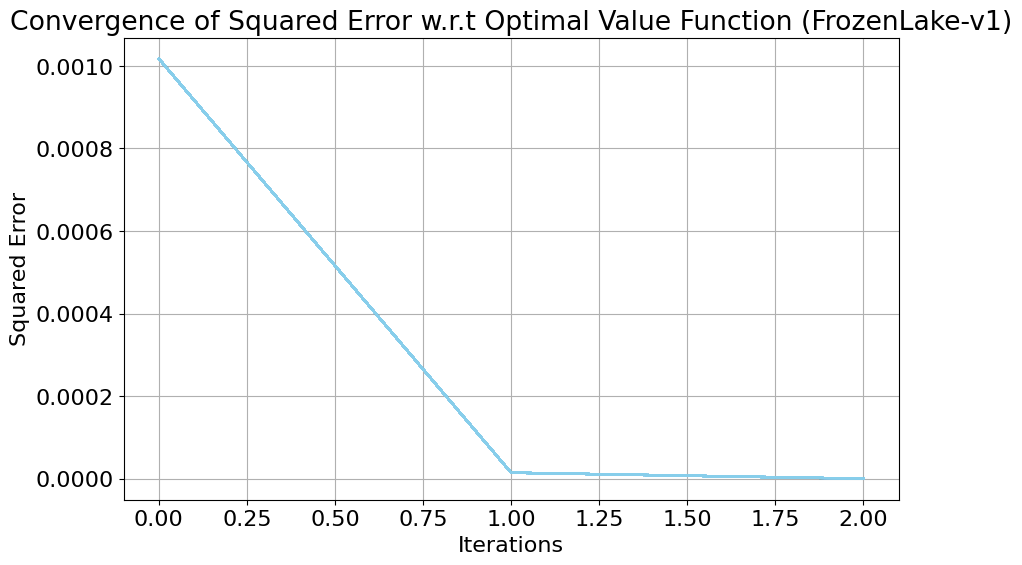

In [402]:
import numpy as np
import matplotlib.pyplot as plt
import gym

def policy_iteration(env, gamma=0.99, theta=1e-8):
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    policy = np.ones((n_states, n_actions)) / n_actions

    def policy_eval(policy):
        V = np.zeros(n_states)
        while True:
            prev_V = np.copy(V)
            for s in range(n_states):
                V[s] = np.sum(policy[s] * [sum(p * (r + gamma * prev_V[s_]) for p, s_, r, _ in env.P[s][a]) for a in range(n_actions)])
            if np.max(np.abs(prev_V - V)) < theta:
                break
        return V

    def policy_improve(V):
        Q = np.zeros((n_states, n_actions))
        for s in range(n_states):
            for a in range(n_actions):
                Q[s][a] = sum(p * (r + gamma * V[s_]) for p, s_, r, _ in env.P[s][a])
        new_policy = np.zeros((n_states, n_actions))
        for s in range(n_states):
            new_policy[s][np.argmax(Q[s])] = 1
        return new_policy

    squared_errors = []
    while True:
        V = policy_eval(policy)
        V_optimal = np.zeros(n_states)
        for s in range(n_states):
            V_optimal[s] = max(sum(p * (r + gamma * V[s_]) for p, s_, r, _ in env.P[s][a]) for a in range(n_actions))
        squared_error = np.sum((V - V_optimal) ** 2) / n_states
        squared_errors.append(squared_error)
        new_policy = policy_improve(V)
        if np.array_equal(policy, new_policy):
            break
        policy = new_policy

    return squared_errors

# Initialize FrozenLake-v1 environment
env = gym.make('FrozenLake-v1')

# Run policy iteration multiple times to collect squared errors over iterations
num_runs = 100
all_squared_errors = []
for _ in range(num_runs):
    squared_errors = policy_iteration(env)
    all_squared_errors.append(squared_errors)

# Plot the convergence of squared error over iterations
plt.figure(figsize=(10, 6))
for squared_errors in all_squared_errors:
    plt.plot(squared_errors, color='skyblue', alpha=0.5)
plt.title('Convergence of Squared Error w.r.t Optimal Value Function (FrozenLake-v1)')
plt.xlabel('Iterations')
plt.ylabel('Squared Error')
plt.grid(True)
plt.show()


In [400]:
# Plot the convergence of squared error over iterations
plt.figure(figsize=(10, 6))
for squared_errors in all_squared_errors:
    plt.plot(squared_errors, color='skyblue', alpha=0.5)
plt.title('Convergence of Squared Error w.r.t Optimal Value Function (FrozenLake-v1)')
plt.xlabel('Iterations')
plt.ylabel('Squared Error')
plt.grid(True)
plt.show()

[[0.0008338673972877314, 1.8876084888222131e-13],
 [0.0008338673972877314, 1.8876084888222131e-13],
 [0.0008338673972877314, 1.8876084888222131e-13],
 [0.0008338673972877314, 1.8876084888222131e-13],
 [0.0008338673972877314, 1.8876084888222131e-13],
 [0.0008338673972877314, 1.8876084888222131e-13],
 [0.0008338673972877314, 1.8876084888222131e-13],
 [0.0008338673972877314, 1.8876084888222131e-13],
 [0.0008338673972877314, 1.8876084888222131e-13],
 [0.0008338673972877314, 1.8876084888222131e-13],
 [0.0008338673972877314, 1.8876084888222131e-13],
 [0.0008338673972877314, 1.8876084888222131e-13],
 [0.0008338673972877314, 1.8876084888222131e-13],
 [0.0008338673972877314, 1.8876084888222131e-13],
 [0.0008338673972877314, 1.8876084888222131e-13],
 [0.0008338673972877314, 1.8876084888222131e-13],
 [0.0008338673972877314, 1.8876084888222131e-13],
 [0.0008338673972877314, 1.8876084888222131e-13],
 [0.0008338673972877314, 1.8876084888222131e-13],
 [0.0008338673972877314, 1.8876084888222131e-13],
